# Project: SkimLit 📄🔥
**Skimming literature**

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.](https://arxiv.org/abs/1710.06071)

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

The paper we're replicating(the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best reuslts is available at: https://arxiv.org/abs/1612.05251



## Confirm access to GPU


In [1]:
!nvidia -smi -L

/bin/bash: line 1: nvidia: command not found


## Get data

Since we'll be replicating the paper above(Pubmed 200k RCT). let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.

Let's check the file contents.

In [3]:
# Check what files are in the Pubmed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:

* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [17]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [18]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess the data

Now we've got some text data, it's time to become one with it.

And one the best ways to become one with the data is to..,
> Visulize..Visualize..Visualize

So with that in the mind, let's write a function to read in all of the lines of a target text file

In [19]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [20]:
#Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") #Read the lines with the training files
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [21]:
len(train_lines)

210040

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (`\t`) and each sentence finishes with a new line (`\n`).

Different abstracts are separated by abstract ID's (lines beginning with `###`) and newlines (`\n`).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.
Let's think about how we want our data to look...

let's try thiss...
```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity .\n",
  'total_lines': 11},
  ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [22]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts  through each line, extracting things
  like the target label, the text of the sentence, how many sentences are in the current
  abstract and what sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = ""  # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the line is an id line
    elif line.isspace(): # Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      # Iterate through each line in a single abstract and count them at same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {} # creates a empty dictionary for each line
        target_text_split = abstract_line.split("\t") # Split target labels from text
        line_data["target"] = target_text_split[0] # get the target label
        line_data["text"] = target_text_split[1].lower() #get the target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: #if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [23]:
# Get data from file and preprocess it
%time
train_samples = preprocess_text_with_line_numbers(data_dir +"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir +"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(test_samples), len(val_samples) )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
180040 30135 30212


In [24]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Fantastic! Looks like our `preprocess_text_with_line_numbers() `function worked great.

Now that our data is the format of a list of dictionaries, how about we run it into
a DataFrame to further visualize it.

In [25]:
import pandas as pd
train_df  = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [26]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Looks like sentences with the `OBJECTIVE `label are the least common.

How about we check the distribution of our abstract lengths?

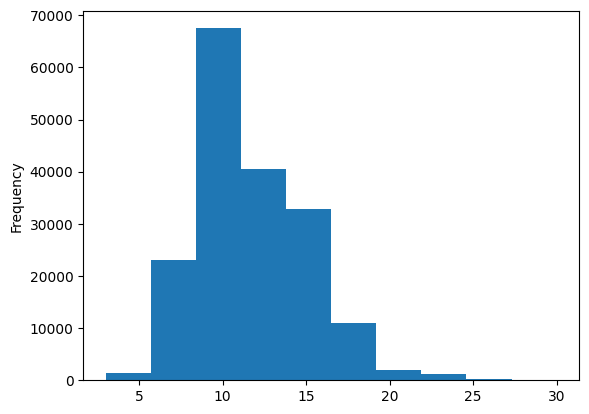

In [27]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

Okay, looks like most of the abstracts are around 7 to 15 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

### Get lists of sentences
When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our `"text"` columns.

In [28]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [29]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's` OneHotEncoder` and `LabelEncoder` classes.

In [30]:
# One hot enode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [31]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [32]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [33]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best. And as always, we're going to start with a baseline`(TF-IDF Multinomial Naive Bayes Classifier)`

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF(Term frequency - inverse document frequency, i.e. tf-idf = tf * idf) formula to convert our words to numbers.

> **Note:** It's common practice to use non-Dl algorithms as a baseline because of their speed and then later using Dl to see if you can improve upon them.

In [21]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [22]:
# Create a tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) #MOdel the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate the model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

Nice! Looks like 72.1% accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [24]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions script

In [25]:
!wget https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/tensorflow_course/helper_functions.py

--2023-09-22 09:34:14--  https://raw.githubusercontent.com/kishan5111/Deep_Learning_Vault/main/notebooks/tensorflow_course/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10415 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.17K  --.-KB/s    in 0s      

2023-09-22 09:34:14 (101 MB/s) - ‘helper_functions.py.1’ saved [10415/10415]



In [26]:
from helper_functions import calculate_results

In [27]:
# calcluate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)

In [28]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data(the text) for deep sequence model

Before we start building deeper models, we've got to create vectorization and embedding layers.  

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).


In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

Let's write some code to find the average length of sentences in the training set.

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

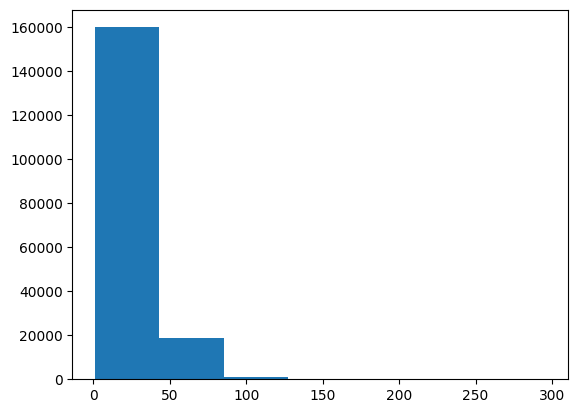

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's `percentile` to find the value which covers 95% of the sentence lengths.

In [32]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

We could use the max sentence length of the sentences in the training set.

In [33]:
# Maximum sequence length in the training set?
max(sent_lens)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

### Create Text Vectorizer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the `TextVectorization `layer from TensorFlow.

We'll keep all the parameters default except for` max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [34]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=max_tokens, #how many words in vocabulary(automatically add<OOV>)
                                    output_sequence_length=55)

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 the objective of the study was to evaluate objective and subjective outcomes of miniarc and monarc ( american medical systems , minnetonka , mn ) midurethral sling ( mus ) in women with stress incontinence at @ months .

Length of text: 39

Vectorized text: [[    2   367     4     2    17    10     6   164   367     3   822    75
      4 25736     3 25689  1035   274  1519 52301 11511  9923  4354  8404
      5    90     7   401  1643    15    41     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Cool, we've now got a way to turn our sequences into numbers.

In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


And if you wanted to figure out the configuration of text_vectorizer you can use the get_config() method.

In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create a custom text embedding

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding.**

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's `Embedding` layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim `parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size output_dim.

Let's see it in action.

In [39]:
from tensorflow.keras  import layers

embedding = layers.Embedding(input_dim = len(rct_20k_text_vocab), #set input length
                             output_dim = 128, #output shape
                             mask_zero=True, # use masking to handle variable sequence lengths(save space)
                             input_length= 55, #how long is each input
                             name="token_embedding")
embedding

In [40]:
# Show example embedding
print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 the objective of the study was to evaluate objective and subjective outcomes of miniarc and monarc ( american medical systems , minnetonka , mn ) midurethral sling ( mus ) in women with stress incontinence at @ months .

Sentence after vectorization (before embedding): 
 [[    2   367     4     2    17    10     6   164   367     3   822    75
      4 25736     3 25689  1035   274  1519 52301 11511  9923  4354  8404
      5    90     7   401  1643    15    41     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [[[ 0.0055119   0.03211519 -0.00509762 ...  0.01667621 -0.03515911
    0.02904048]
  [ 0.03182683  0.00578785 -0.00914102 ... -0.03460339  0.01402325
   -0.03101493]
  [ 0.01530056  0.03751994 -0.00441326 ...  0.04766632 -0.04773676
    0.03990689]
  ...
  [ 0.04896358  0.0182822   0.02735696 ...  0.00916042  0.0388121
   

## Creating datasets (making sure our data loads as fast as possible)



We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data `API provides methods which enable faster data loading.

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset =  tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [43]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

> Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

 * Build model
 * Train model
 * Evaluate model (make predictions and compare to ground truth)


In [44]:
from tensorflow.keras import layers

# Build the model
inputs = layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5,  activation="relu", padding ="same")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D")

# Compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam())

In [45]:
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                    

Wonderful! We've got our first deep sequence model built and ready to go.

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim `parameter of the` Embedding` layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [46]:
history_model_1 = model_1.fit(train_dataset,
                              validation_data=(valid_dataset),
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_steps=int(len(valid_dataset) * 0.10))

Epoch 1/3
562/562 [==============================] - 34s 55ms/step - loss: 0.8395 - accuracy: 0.6799 - val_loss: 0.5954 - val_accuracy: 0.7822
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.5810 - accuracy: 0.7876 - val_loss: 0.5434 - val_accuracy: 0.7965
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.5443 - accuracy: 0.8004 - val_loss: 0.5199 - val_accuracy: 0.8072


Brilliant! We've got our first trained deep sequence model, and it didn't take too long (and if we didn't prefetch our batched data, it would've taken longer).

Time to make some predictions with our model and then evaluate them.

In [47]:
# Evaluate on validation data
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5217 - accuracy: 0.8080


[0.521746814250946, 0.807957112789154]

In [48]:
# Make prediction(model_predicts prediction probabilities for each class)
model_1_pred_probs =  model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [49]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 4, 4, 2, 4, 1])>

In [50]:
# Calculate model_1 results
model_1_results= calculate_results(y_pred=model_1_preds,
                                   y_true=val_labels_encoded)

In [51]:
model_1_results, baseline_results

({'accuracy': 80.79571031378259,
  'precision': 0.8066483746616887,
  'recall': 0.807957103137826,
  'f1': 0.806234405658868},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

## Model 2: Feature extraction with pretrained  token embedding
Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The model structure will look like:

> Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

In [52]:
import tensorflow_hub as hub
# Create a Keras layer using the USE pretrained layer from tensorflowhub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable= False,
                                        name="USE-large")

In [53]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = sentence_encoder_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence:
the discontinuation rates caused by adverse events were low in both the groups .

Sentence after embedding:
[ 0.02607075 -0.02122167  0.01823029  0.03836692 -0.05099753 -0.03887452
 -0.05781492 -0.02452217 -0.00148008  0.01899404 -0.0291895  -0.00926553
 -0.06614975  0.01594319 -0.02297254  0.02433222 -0.0623586  -0.04317022
  0.00137402 -0.07767948 -0.00878598 -0.06120852  0.04846364  0.07014403
  0.00582416 -0.01219499 -0.0371583  -0.08567472 -0.03218959  0.03590577] (truncated output)...

Length of sentence embedding:
512


In [54]:
# Building the model
model_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE-large (KerasLayer)      (None, 512)               147354880 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 147421189 (562.37 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 147354880 (562.11 MB)
_________________________________________________________________


In [55]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              validation_data=(valid_dataset),
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 57s 62ms/step - loss: 0.8285 - accuracy: 0.6914 - val_loss: 0.6869 - val_accuracy: 0.7414
Epoch 2/3
562/562 [==============================] - 32s 57ms/step - loss: 0.6661 - accuracy: 0.7496 - val_loss: 0.6473 - val_accuracy: 0.7566
Epoch 3/3
562/562 [==============================] - 32s 56ms/step - loss: 0.6386 - accuracy: 0.7578 - val_loss: 0.6216 - val_accuracy: 0.7590


In [56]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 43s 45ms/step - loss: 0.6278 - accuracy: 0.7608


[0.6278000473976135, 0.7608234882354736]

In [57]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

945/945 [==============================] - 46s 44ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 2, 4, 2, 2, 4, 4, 1])>

In [58]:
# Calulate results Tfhub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.0823513835562,
 'precision': 0.7593258556079533,
 'recall': 0.760823513835562,
 'f1': 0.7590061042299857}

## Model 3: Conv1D with character embeddings
The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [59]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [10]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

Great! Looks like our character-splitting function works. Let's create character-level datasets by splitting our sequence datasets into characters.

In [61]:
# Text splitting non-character-level sequence into characters
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [62]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence)for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [63]:
# What's the average character length?
chars_length = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_length)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

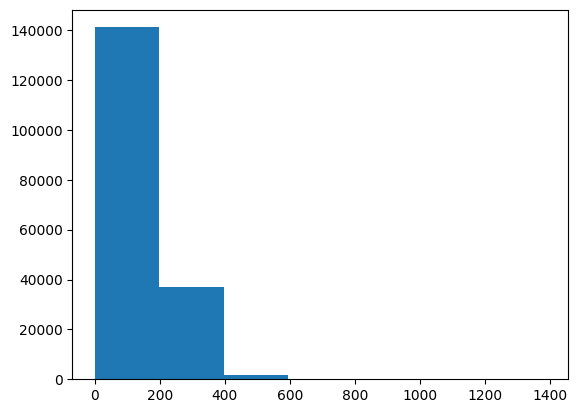

In [64]:
# Check the distribution of our sentence ar a character level
import matplotlib.pyplot as plt
plt.hist(chars_length, bins=7)

In [65]:
# Find what character length cover 95% of sequences
output_seq_char_len = int(np.percentile(chars_length, 95))
output_seq_char_len

290

In [66]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(len(alphabet), alphabet)

68 abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [67]:
# Create char-level tokenvectorier instance
NUM_CHAR_TOKENS = len(alphabet) + 2 #add 3 for space and OOV token(OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    # standardize=None,
                                    name="char_vectorizer")

In [68]:
# Adapt to training chars
char_vectorizer.adapt(train_chars)

In [69]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 Most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [70]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of Vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 p a t i e n t s   m a n a g e d   w i t h   l d s   a t t a i n e d   @   %   s u c c e s s   r a t e   a n d   t h o s e   w i t h o u t   l d   a t t a i n e d   @   %   ;   t h e   d i f f e r e n c e   i s   n o t   s i g n i f i c a n t   (   p   =   @   )   .

Length of random_train_chars: 106

Vectorized chars:
 [[14  5  3  4  2  6  3  9 15  5  6  5 18  2 10 20  4  3 13 12 10  9  5  3
   3  5  4  6  2 10  9 16 11 11  2  9  9  8  5  3  2  5  6 10  3 13  7  9
   2 20  4  3 13  7 16  3 12 10  5  3  3  5  4  6  2 10  3 13  2 10  4 17
  17  2  8  2  6 11  2  4  9  6  7  3  9  4 18  6  4 17  4 11  5  6  3 14
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Create a  Character level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the `tensorflow.keras.layers.Embedding class.`

Our character-level embedding layer requires an input dimension and output dimension.

In [71]:
from tensorflow.keras import layers

char_embedding = layers.Embedding(input_dim = len(char_vocab),
                                  output_dim = 25, #this is size of the char embed in paper
                                  mask_zero=True,
                                  name = "character_embedding")

In [72]:
# Show sample char embedding
print(f"Sentence before vectorization: \n {random_train_chars}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Sentence after vectorization(before embedding):\n {vectorized_chars}\n")
char_embedded = char_embedding(vectorized_chars)
print(f"Sentence after embedding:\n{char_embedded}\n")
print(f"Embedded char sentence shape:{char_embedded.shape}")

Sentence before vectorization: 
 p a t i e n t s   m a n a g e d   w i t h   l d s   a t t a i n e d   @   %   s u c c e s s   r a t e   a n d   t h o s e   w i t h o u t   l d   a t t a i n e d   @   %   ;   t h e   d i f f e r e n c e   i s   n o t   s i g n i f i c a n t   (   p   =   @   )   .

Sentence after vectorization(before embedding):
 [[14  5  3  4  2  6  3  9 15  5  6  5 18  2 10 20  4  3 13 12 10  9  5  3
   3  5  4  6  2 10  9 16 11 11  2  9  9  8  5  3  2  5  6 10  3 13  7  9
   2 20  4  3 13  7 16  3 12 10  5  3  3  5  4  6  2 10  3 13  2 10  4 17
  17  2  8  2  6 11  2  4  9  6  7  3  9  4 18  6  4 17  4 11  5  6  3 14
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Building a Conv1D model to fit on character embeddings

In [73]:
# Make Conv1D on char embedding
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [74]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 290, 25)           700       
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                     

In [75]:
#Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2660 - accuracy: 0.4817 - val_loss: 1.0594 - val_accuracy: 0.5778
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0191 - accuracy: 0.5941 - val_loss: 0.9625 - val_accuracy: 0.6130
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9395 - accuracy: 0.6294 - val_loss: 0.8916 - val_accuracy: 0.6562


In [77]:
# Make prediction character model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

945/945 [==============================] - 3s 3ms/step


In [78]:
# calculate results foe connv1d model
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred= model_3_preds)

In [79]:
model_3_results

{'accuracy': 65.2720773202701,
 'precision': 0.6512721903900508,
 'recall': 0.6527207732027009,
 'f1': 0.6414327941623363}

## Model 4: Combining pretrained token embeddings + character embeddings(hybrid embedding layer)

1. Create a token-level embedding(similar `model_1`)
2. Create a character-level model(similar to `model_3` with slight modification)
3. Combine 1 & 2 with concatenate(`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [80]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs(create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout in section of paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)


In [81]:
# Get summary
model_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE-large (KerasLayer)      (None, 512)                  1473548   ['token_input[0][0]']   

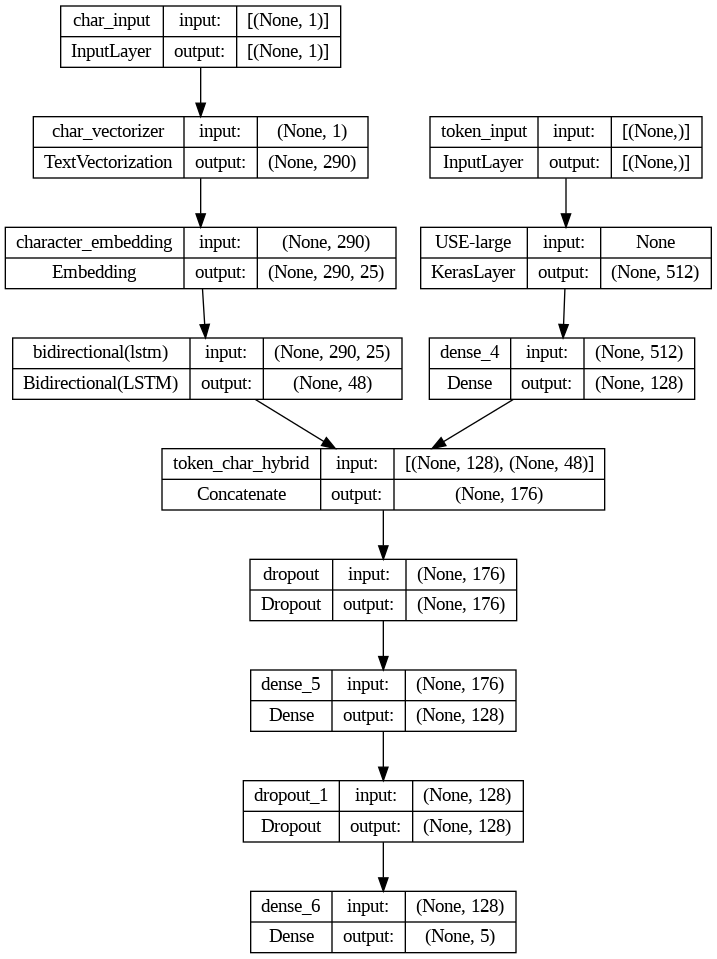

In [82]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [83]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [84]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,valid_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [87]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 76s 103ms/step - loss: 0.9067 - accuracy: 0.6403 - val_loss: 0.6860 - val_accuracy: 0.7291
Epoch 2/3
562/562 [==============================] - 56s 99ms/step - loss: 0.7166 - accuracy: 0.7310 - val_loss: 0.6320 - val_accuracy: 0.7593
Epoch 3/3
562/562 [==============================] - 46s 81ms/step - loss: 0.6776 - accuracy: 0.7456 - val_loss: 0.6010 - val_accuracy: 0.7773


In [88]:
# Evaluating the model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6055 - accuracy: 0.7744


[0.6054982542991638, 0.7743611931800842]

In [89]:
# Get the predictions
model_4_preds_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 56s 51ms/step


In [90]:
# Round the preds
preds_model_4 = tf.argmax(model_4_preds_probs, axis=1)
preds_model_4

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [91]:
# Calulate the evaluation matrix
model_4_results = calculate_results(y_pred=preds_model_4,
                                    y_true=val_labels_encoded)
model_4_results

{'accuracy': 77.43942804183767,
 'precision': 0.7724931538027271,
 'recall': 0.7743942804183768,
 'f1': 0.7724801937995577}

In [ ]:
import gc


>**Note**: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called `feature engineering.`

### Create positional embeddings

Since our `"line_number" `and `"total_line" `columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the `tf.one_hot `utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the `"line_number"` column.

>**🔑 Note:**When it comes to one-hot-encoding our features, Scikit-Learn's OneHotEncoder class is another viable option here.

In [92]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

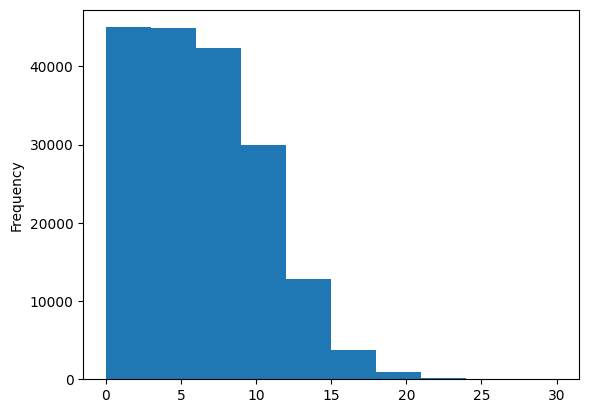

In [93]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [94]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [95]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [96]:
# How many total lines are there?
train_df["total_lines"].value_counts().sort_index()

3        32
4       215
5      1146
6      3353
7      7464
8     12285
9     19400
10    23639
11    24468
12    22113
13    18438
14    14610
15    10768
16     7429
17     5202
18     3344
19     2480
20     1281
21      770
22      759
23      264
24      200
25      182
26       81
27       28
28       58
30       31
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

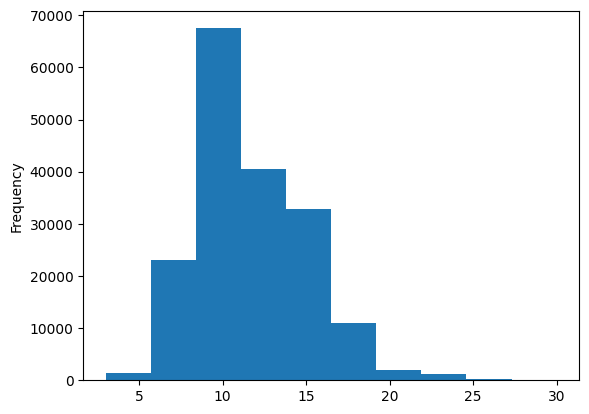

In [97]:
# Check the distribution of "line_number" column
train_df.total_lines.plot.hist()

In [98]:
# Check teh coverage of a total line value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [99]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines"
feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [100]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. line numbers model
line_inputs = layers.Input(shape=(15,) , dtype=tf.float32, name="line_numbers_inputs")
x = layers.Dense(32, activation="relu")(line_inputs)
line_number_model = tf.keras.Model(line_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

# 5. Concatenate token and char inputs(create hybrid token embedding)
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine the positional embedding with combined token and char embedings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [101]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE-large (KerasLayer)      (None, 512)                  1473548   

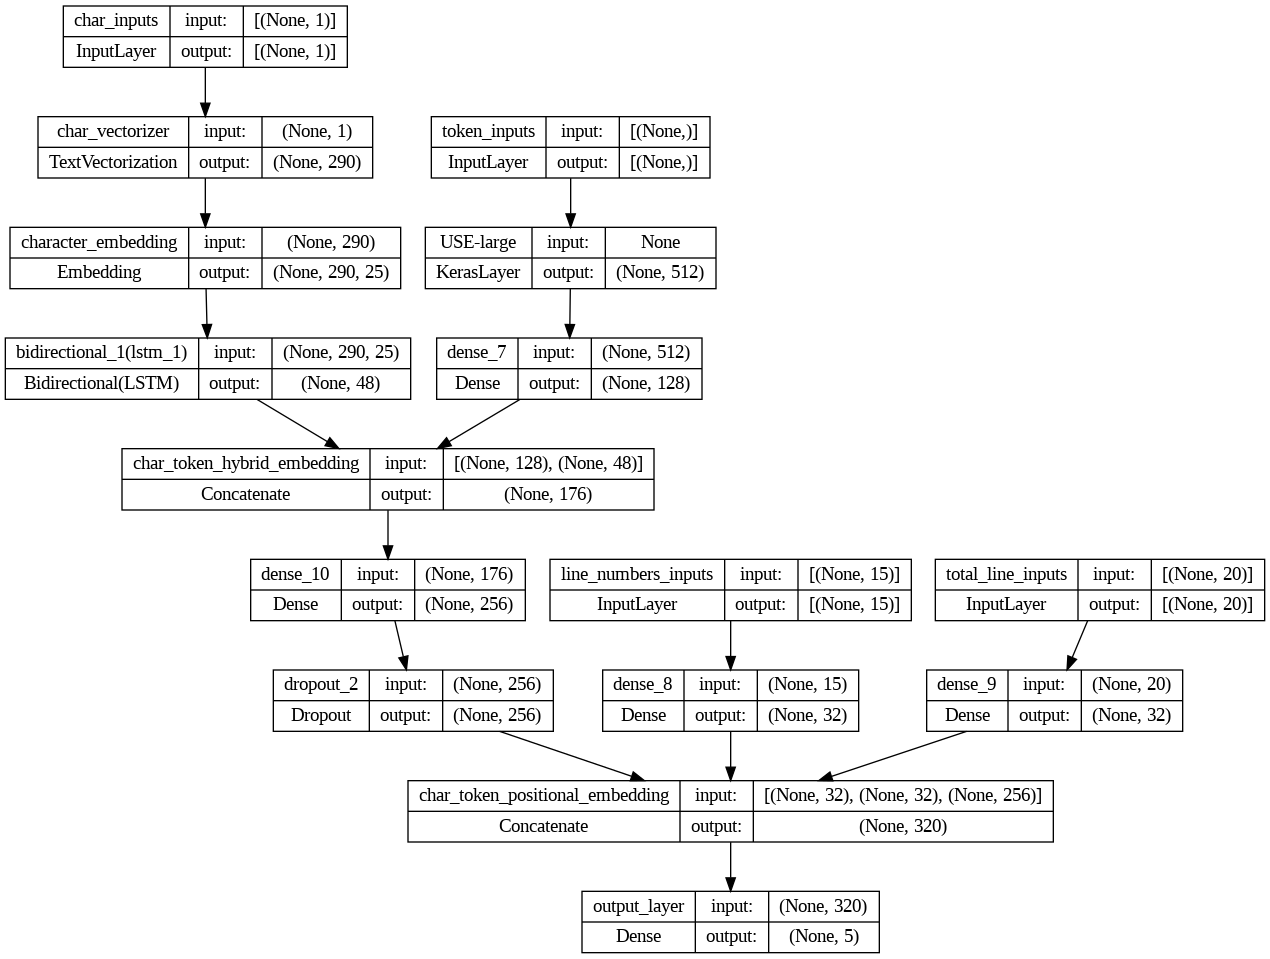

In [102]:
# plot model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True )

Visualizing the model makes it much easier to understand.

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

In [103]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f06ee8099c0> True
<keras.src.engine.input_layer.InputLayer object at 0x7f063c2d4340> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f05d0e85fc0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f065e3d3a90> False
<keras.src.layers.core.embedding.Embedding object at 0x7f064c149f90> True
<keras.src.layers.core.dense.Dense object at 0x7f05d0102980> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7f05f1aa8b50> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7f05d040bbb0> True
<keras.src.engine.input_layer.InputLayer object at 0x7f05d046f160> True
<keras.src.engine.input_layer.InputLayer object at 0x7f05d05b4610> True
<keras.src.layers.core.dense.Dense object at 0x7f063aa82fe0> True
<keras.src.layers.core.dense.Dense object at 0x7f05e94d18a0> True
<keras.src.layers.core.dense.Dense object at 0x7f05d0115f00> True
<keras.src.layers.regularization.dropout.

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.02, 0.01, 0.96, 0.01, 0.01]`

In [104]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps to prevent overfitting
                optimizer= "adam",
                metrics=["accuracy"])

### Create tribrid embedding datasets using `tf.data`

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:

 1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
 2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
 3. Token-level sequences tensor (`train_sentences`)
 4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset's.`

In [105]:
train_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_data, train_labels))

val_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,valid_chars))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_data, val_labels))

test_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))

# Prefetch and batch data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [106]:
train_dataset, val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making prediction with tribrid model

In [107]:
history_model_5 =  model_5.fit(train_dataset,
                               epochs=3,
                               steps_per_epoch= int(0.1* len(train_dataset)),
                               validation_data=(val_dataset),
                               validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 74s 100ms/step - loss: 1.0667 - accuracy: 0.7434 - val_loss: 0.9579 - val_accuracy: 0.8158
Epoch 2/3
562/562 [==============================] - 48s 85ms/step - loss: 0.9441 - accuracy: 0.8293 - val_loss: 0.9251 - val_accuracy: 0.8404
Epoch 3/3
562/562 [==============================] - 45s 80ms/step - loss: 0.9211 - accuracy: 0.8441 - val_loss: 0.9124 - val_accuracy: 0.8491


In [108]:
# Make prediction with the char token pos model
model_5_pred_probs = model_5.predict(val_dataset, verbose=1)
# Conver pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

945/945 [==============================] - 58s 52ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 4, 1])>

In [109]:
# Calculate the results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.01919766980008,
 'precision': 0.8486069262280562,
 'recall': 0.8501919766980008,
 'f1': 0.8492001622355937}

## Compare model results
Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [110]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_custom_char_embedding": model_3_results,
                                 "model_4_hybrid_char_token_embedding": model_4_results,
                                 "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,80.795710,0.806648,0.807957,0.806234
model_2_pretrained_token_embedding,76.082351,0.759326,0.760824,0.759006
model_3_custom_char_embedding,65.272077,0.651272,0.652721,0.641433
model_4_hybrid_char_token_embedding,77.439428,0.772493,0.774394,0.772480
model_5_pos_char_token_embedding,85.019198,0.848607,0.850192,0.849200


In [111]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

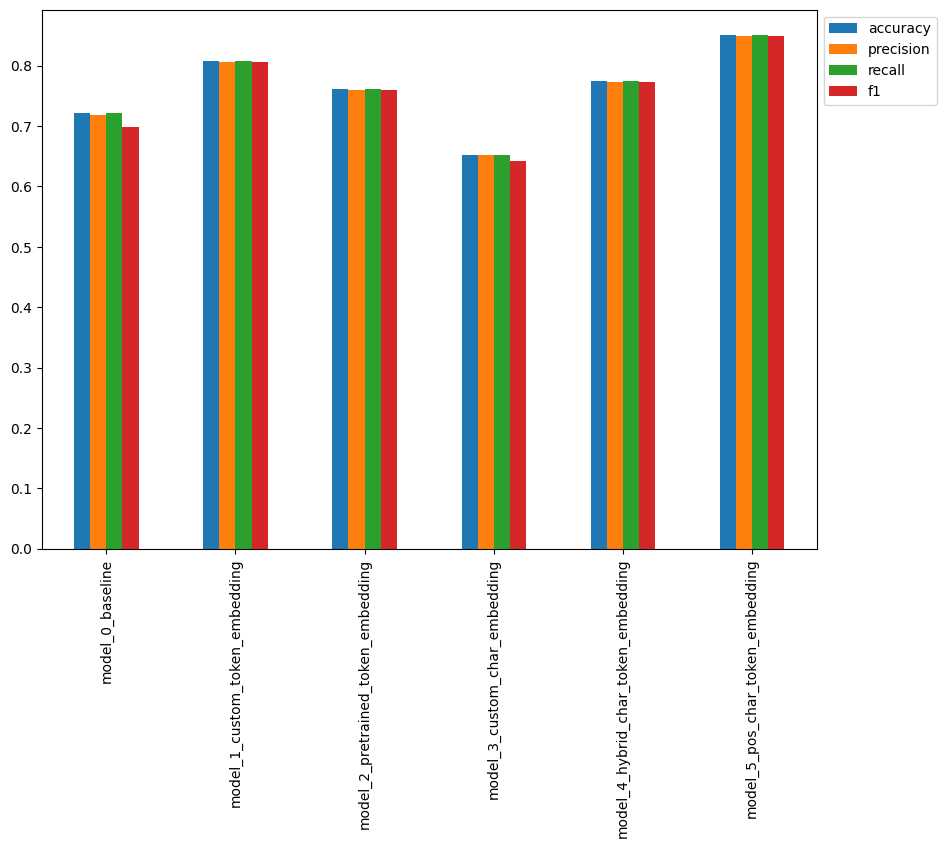

In [112]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

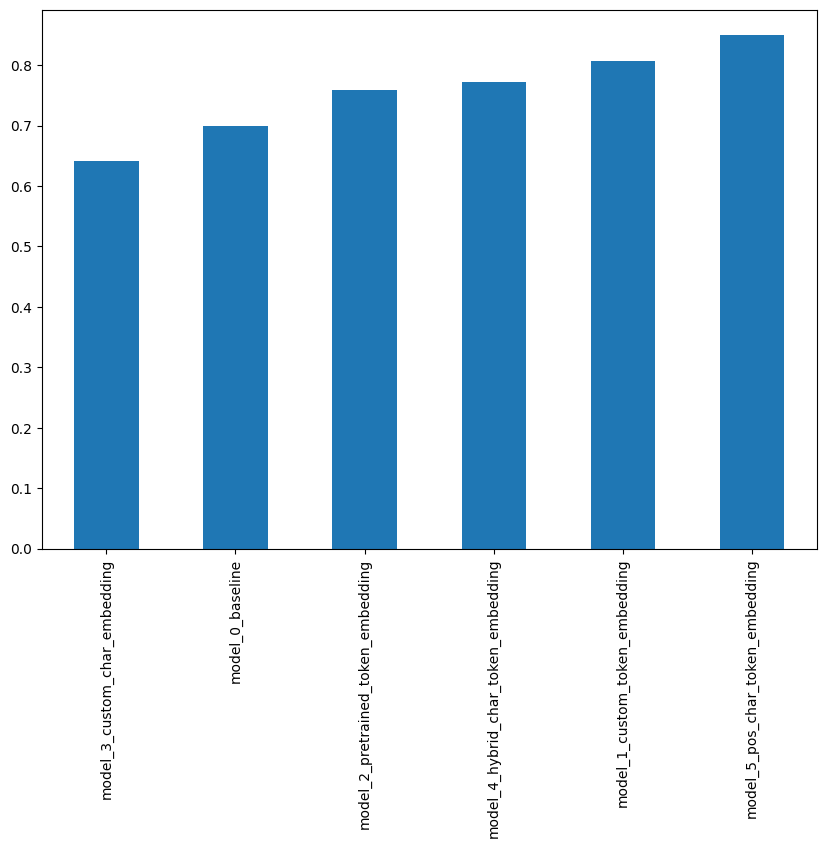

In [113]:
# Sort model results by f1_score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Save and load model
Since we've been through a fair few experiments, it's a good idea to save our best performing model so we can reuse it without having to retrain

In [ ]:
# Save the best performing model to SaveModel format (default)
model_5.save("skimlit_tribrid_model")

In [116]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-09-22 09:55:48--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  62.8MB/s    in 16s     

2023-09-22 09:56:04 (55.9 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_m

In [1]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

## Make predictions and evalaute them against the truth labels
To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [118]:
# Make predictions with the loaded model on the validation set
loaded_model_preds_probs = loaded_model.predict(val_dataset)
loaded_preds = tf.argmax(loaded_model_preds_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 19s 18ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [119]:
# calculate the loaded model results
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [120]:
model_5_results

{'accuracy': 85.01919766980008,
 'precision': 0.8486069262280562,
 'recall': 0.8501919766980008,
 'f1': 0.8492001622355937}

In [121]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([False, False, False, False])

In [122]:
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

## Evaluate model on test dataset

In [123]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 17s 18ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [124]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

## Find most wrong
One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.

In [125]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 14.8 s, sys: 724 ms, total: 15.5 s
Wall time: 14.6 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

Now we'll enrich our test DataFame with a few values:

* A "`prediction`" (string) column containing our model's prediction for a given sample.
* A "`pred_prob`" (float) column containing the model's maximum prediction probabiliy for a given sample.
* A "`correct`" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [126]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802458,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


Great (or not so great)! Now we've got a subset of our model's most wrong predictions, let's write some code to visualize them.

Looking good! Having our data like this, makes it very easy to manipulate and view in different ways.

How about we sort our DataFrame to find the samples with the highest "`pred_prob`" and where the prediction was wrong ("`correct" == False)`?

In [128]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
...,...,...,...,...,...,...,...
12134,RESULTS,we conducted a population-based case-control s...,2,16,METHODS,0.840899,False
2605,RESULTS,"circulating epc ( cells positive for cd@ , cd@...",4,10,METHODS,0.840442,False
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.840310,False
20003,CONCLUSIONS,most subjects with bronchospasm responded to r...,9,11,RESULTS,0.839986,False


In [129]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9467191696166992, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9349740743637085, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9309859275817871, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9282616972923279, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.918879508972168, Line number: 0, Total lines: 10

Text:
to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) 

A next step here would be if there are a fair few samples with inconsistent labels, you could go through your training dataset, update the labels and then retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as **active learning**.

## Make example predictions
we've made some predictions on the test dataset, now's time to really test our model out.

To do so, we're going to get some data from the wild and see how our model performs.

In other words, were going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the wild abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

We'll use the below from https://pubmed.ncbi.nlm.nih.gov/20232240/:
> This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Looking at the large chunk of text can seem quite intimidating. Now imagine you're a medical researcher trying to skim through the literature to find a study relevant to your work.

Sounds like quite the challenge right?

Enter SkimLit 🤓🔥!

Let's see what our best model so far (model_5) makes of the above abstract.

But wait...

As you might've guessed the above abstract hasn't been formatted in the same structure as the data our model has been trained on. Therefore, before we can make a prediction on it, we need to preprocess it just as we have our other sequences.

More specifically, for each abstract, we'll need to:

 1. Split it into sentences (lines).
 2. Split it into characters.
 3. Find the number of each line.
 4. Find the total number of lines.

In [2]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-09-22 10:03:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-09-22 10:03:07 (99.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [4]:
import pandas as pd

# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


Now we've downloaded some example abstracts, let's see how one of them goes with our trained model.

First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.

In [5]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

Beautiful! It looks like spaCy has split the sentences in the abstract correctly. However, it should be noted, there may be more complex abstracts which don't get split perfectly into separate sentences (such as the example in [Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection](https://pubmed.ncbi.nlm.nih.gov/22244707/)), in this case, more custom splitting techniques would have to be investigated.

Now our abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.

To do so, we can leverage some of the functionality of our `preprocess_text_with_line_numbers()` function.

In [6]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [7]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [8]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [11]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

Alright, now we've preprocessed our wild RCT abstract into all of the same features our model was trained on, we can pass these features to our model and make sequence label predictions!

In [12]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 6s 6s/step
CPU times: user 2.58 s, sys: 422 ms, total: 3 s
Wall time: 6.22 s


array([[0.26448247, 0.11054241, 0.01762423, 0.5750656 , 0.03228523],
       [0.06927066, 0.03808297, 0.7078093 , 0.09543166, 0.08940544],
       [0.13772689, 0.04937518, 0.546797  , 0.1634129 , 0.10268807],
       [0.09659057, 0.1711164 , 0.52574384, 0.07601643, 0.13053277],
       [0.04459698, 0.08888115, 0.4567545 , 0.04623033, 0.363537  ],
       [0.03265216, 0.1462643 , 0.517485  , 0.04088319, 0.2627154 ],
       [0.03290153, 0.1779621 , 0.07166822, 0.02870874, 0.6887594 ],
       [0.01843721, 0.13495176, 0.32084182, 0.03389723, 0.49187204]],
      dtype=float32)

In [13]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

Now we've got the predicted sequence label for each line in our sample abstract, let's write some code to visualize each sentence with its predicted label.

In [34]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [36]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}\n")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS: Participants were randomly assigned to treatment or wait-list conditions.

METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.



Nice! Isn't that much easier to read and cool?